In [1]:
# Import libraries
import geopandas as gpd
import matplotlib as mpl
import numpy as np

In [2]:
# For plot to appear in the notebook
%matplotlib inline 

# Import initial data

In [3]:
# Set the path to the original shapefile
admin1_shape="/media/tais/data/Dropbox/ULB/MAUPP/Coordination collaborateurs sur place/WP6_populeation_limitesadmin/Dakar_StLouis/Dakar_admin5_topological_clean/Dakar_units_core_cleaned.shp"

In [4]:
# Read the shapefile
gdf1 = gpd.read_file(admin1_shape)
# Display the attribute table
gdf1.head()

,Department,Area4,Area5,Id_area5,Code,Commune,Quartier,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,Shape_Leng,Shape_Area,geometry
0,PIKINE,MBAO,CITE NDEYE MARIE,1.230135e+11,1.230135e+11,Mbao,CITE NDEYE MARIE,310,343,1124,1142,2266,1455.303455,104294.145207,"POLYGON ((250391.4934 1629353.1556, 250319.658..."
1,PIKINE,MBAO,NDOYENE SOUF,1.230135e+11,1.230135e+11,Mbao,NDOYENE SOUF,55,124,545,575,1120,1091.641874,53131.494372,"POLYGON ((249750.3291999996 1629808.9005, 2497..."
2,PIKINE,MBAO,NDIOBENE,1.230135e+11,1.230135e+11,Mbao,NDIOBENE,92,123,542,508,1050,1215.072916,54988.418054,"POLYGON ((250113.2289000005 1629602.2348, 2501..."
3,PIKINE,MBAO,LAMSAR,1.230135e+11,1.230135e+11,Mbao,LAMSAR,65,131,498,460,958,798.618709,32725.663230,"POLYGON ((250155.7130000005 1629917.0689, 2501..."
4,PIKINE,MBAO,NDOYENE KAW,1.230135e+11,1.230135e+11,Mbao,NDOYENE KAW,115,172,740,753,1493,1149.657763,73620.459691,"POLYGON ((249878.8282000003 1630025.5766, 2498..."


In [5]:
# Keep only columns with population data (quantitative) that could be aggregated using a "grouby - sum" function
# Be carefull to keep the geometry column
gdf1 = gdf1.loc[:,['geometry','CONCESSION','MENAGE', 'HOMME', 'FEMME', 'POPULATION']] #Adapt the column names according to your own data
# Add two columns to the attribute table with x (long) and y (lat)
gdf1["x"] = gdf1.centroid.map(lambda p: p.x)
gdf1["y"] = gdf1.centroid.map(lambda p: p.y)

In [29]:
# Display the attribute table
gdf1.head()

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,x,y,cluster
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266,250415.671612,1629636.035596,73
1,"POLYGON ((249750.3291999996 1629808.9005, 2497...",55,124,545,575,1120,249673.014011,1629686.216988,73
2,"POLYGON ((250113.2289000005 1629602.2348, 2501...",92,123,542,508,1050,249951.172254,1629563.238497,73
3,"POLYGON ((250155.7130000005 1629917.0689, 2501...",65,131,498,460,958,249989.434381,1629922.971439,73
4,"POLYGON ((249878.8282000003 1630025.5766, 2498...",115,172,740,753,1493,249696.999188,1629965.857461,73


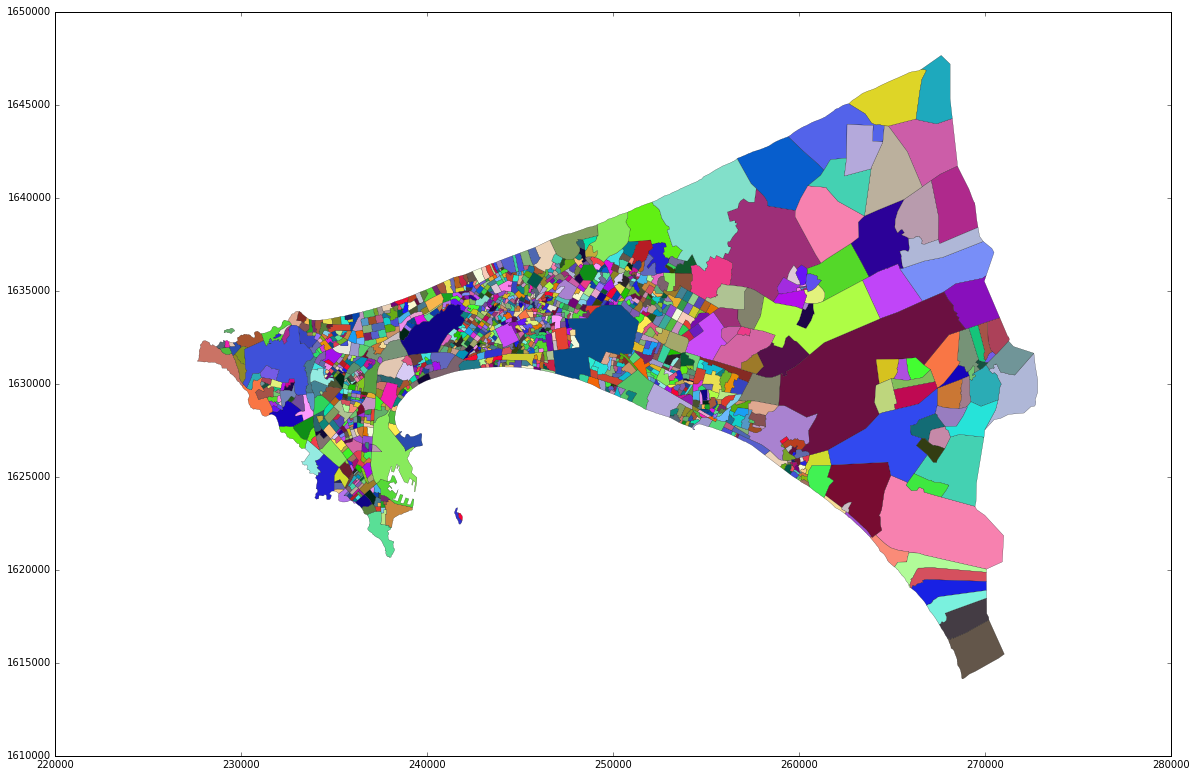

In [7]:
# A random colormap for matplotlib
cmap = mpl.colors.ListedColormap(np.random.rand(256,3))
# Display the shape
gdf1.plot(cmap=cmap, lw=0.2, figsize=(20,20))

# Kmeans clustering

In [8]:
# Getting the x/y values
f1 = gdf1['x'].values
f2 = gdf1['y'].values
X = np.array(list(zip(f1, f2)))

# Run Kmeans clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=150).fit(X) # Here you can change the number of clusters you desire
labels = kmeans.predict(X) # Getting the cluster labels

In [9]:
# Joint results to the attribute table
gdf1["cluster"] = labels
# Display the attribute table
gdf1.head()

,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,x,y,cluster
0,"POLYGON ((250391.4934 1629353.1556, 250319.658...",310,343,1124,1142,2266,250415.671612,1629636.035596,73
1,"POLYGON ((249750.3291999996 1629808.9005, 2497...",55,124,545,575,1120,249673.014011,1629686.216988,73
2,"POLYGON ((250113.2289000005 1629602.2348, 2501...",92,123,542,508,1050,249951.172254,1629563.238497,73
3,"POLYGON ((250155.7130000005 1629917.0689, 2501...",65,131,498,460,958,249989.434381,1629922.971439,73
4,"POLYGON ((249878.8282000003 1630025.5766, 2498...",115,172,740,753,1493,249696.999188,1629965.857461,73


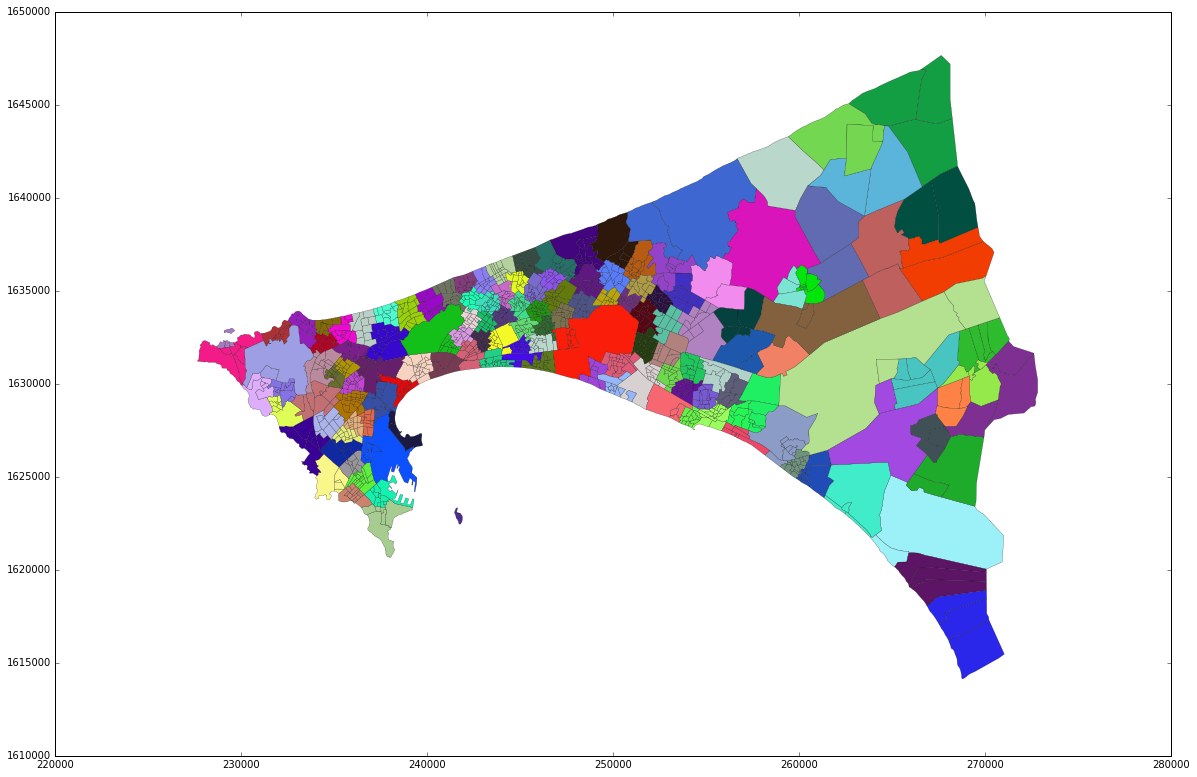

In [159]:
# A random colormap for matplotlib
cmap = mpl.colors.ListedColormap(np.random.rand(256,3))
# Display the shape
gdf1.plot(column='cluster', cmap=cmap, lw=0.2, figsize=(20, 20))  #Adapt the column according to your own data

# Dissolve admin1 level to get admin0 level

In [140]:
def dissolve_admin1_to_admin0(gdf1, gdf0):
    # Use dissolve function of Geopandas
    gdf0 = gdf1.dissolve(by='cluster', aggfunc='sum', as_index=False)
    gdf0.drop(['x', 'y'], axis=1, inplace=True) # Drop 'x' and 'y' columns since their sum do not have sense
    # Add count of admin1 unit in each cluster
    count_units = gdf1.dissolve(by='cluster', aggfunc='count', as_index=False)['x']
    gdf0['count'] = count_units
    return gdf0

In [141]:
# Dissolve admin1 level accordint to 'cluster' column to get admin0
gdf0 = dissolve_admin1_to_admin0(gdf1, gdf0)

In [142]:
# Display the attribute table
gdf0.head()

,cluster,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,count
0,0,"POLYGON ((246143.1075999998 1634532.085100001,...",2752,4989,21252,20492,41744,19
1,1,"POLYGON ((237347.6672 1630479.2864, 237338.618...",3616,11148,29062,28494,57558,14
2,2,"POLYGON ((256034.9601999996 1627967.2733, 2560...",1861,3148,12397,12495,24894,15
3,3,"POLYGON ((261255.0985000003 1634422.6216, 2610...",381,489,2173,2147,4320,8
4,4,"POLYGON ((250644.0654999996 1635180.348999999,...",2691,3811,15104,15388,30492,13


## If cluster are compouned by 1 unit only, merge with the smallest neighboring cluster

In [113]:
# Declare a function that check how many cluster are composed of only have one unit 
def check_remaining_single_cluster(df):
    global count_dict
    count_dict={x.cluster:x['count'] for i,x in df.iterrows()}
    number_single_cluster = len(df.loc[df['count']<2])
    return number_single_cluster

In [114]:
# Declare a function that add a "NEIGHBORS" column with id of neighboring clusters 
def find_neighbors(gdf, unique_id="cluster"):
    gdf["NEIGHBORS"] = None  # Add empty NEIGHBORS column
    for index, unit in gdf.iterrows():   
        # get 'not disjoint' countries
        neighbors = gdf[~gdf.geometry.disjoint(unit.geometry)][unique_id].tolist()
        # remove own name from the list
        neighbors = [str(Id) for Id in neighbors if unit[unique_id] != Id]
        # add names of neighbors as NEIGHBORS value
        gdf.at[index, "NEIGHBORS"] = ", ".join(neighbors)

In [115]:
# Declare a function that return the id of the smallest neighborhing cluster 
def check_smallest_cluster(_dict, _list):
        neighbor_id=[int(x) for x in _list.split(',')]
        candidate_value=_dict[neighbor_id[0]]
        candidate_id=neighbor_id[0]
        for x in neighbor_id[1:]:
            if _dict[x] < candidate_value:
                candidate_value=_dict[x]
                candidate_id=x
        return candidate_id

In [143]:
find_neighbors(gdf0)

In [144]:
# Display the attribute table
gdf0.head()

,cluster,geometry,CONCESSION,MENAGE,HOMME,FEMME,POPULATION,count,NEIGHBORS
0,0,"POLYGON ((246143.1075999998 1634532.085100001,...",2752,4989,21252,20492,41744,19,"26, 70, 71, 121, 125, 140"
1,1,"POLYGON ((237347.6672 1630479.2864, 237338.618...",3616,11148,29062,28494,57558,14,"19, 24, 29, 55, 78, 82, 102, 149"
2,2,"POLYGON ((256034.9601999996 1627967.2733, 2560...",1861,3148,12397,12495,24894,15,"85, 96, 123, 124, 143"
3,3,"POLYGON ((261255.0985000003 1634422.6216, 2610...",381,489,2173,2147,4320,8,"112, 129, 136, 138"
4,4,"POLYGON ((250644.0654999996 1635180.348999999,...",2691,3811,15104,15388,30492,13,"25, 61, 62, 68, 72, 120, 127"


In [145]:
len(gdf0)

146

In [146]:
check_remaining_single_cluster(gdf0)  # remaining variable takes number of cluster remaining with only 1 original unit

14

In [168]:
## Minimum original units per cluster 
min_units = 2

## As long as there remain issues (clusters with only one admin unit) merge it with the neighboring cluster that have the smallest number of admin units
remaining = check_remaining_single_cluster(gdf0)  # remaining variable takes number of cluster remaining with only 1 original unit
if remaining == 0:
    print "Nothing to fix: All clusters are compouned by at least two original administrative units"
else:
    while remaining > 0:
        print "Fixing issue..."
        for index, unit in gdf0.iterrows():   
            if unit['count'] < min_units:
                print "   -> cluster %s only have 1 original unit"%unit['cluster']
                list_neighbors=unit.NEIGHBORS
                candidate_cluster=check_smallest_cluster(count_dict,list_neighbors)
                print "   -> will be merge with cluster %s"%candidate_cluster
                # Update the value of 'cluster' column (result of Kmeans) with the new candidate cluster
                gdf1['cluster'] = gdf1.cluster.apply(lambda x: candidate_cluster if x == unit['cluster'] else x)  
                break  # Allow to operate dissolving one by one
        # Dissolve according to the updated cluster membership
        print 'dissolve'
        gdf0 = dissolve_admin1_to_admin0(gdf1, gdf0)
        find_neighbors(gdf0)
        remaining = check_remaining_single_cluster(gdf0)
        print 'remaining issues : %s'%remaining
    print "\nAll issues have been removed: All clusters are compouned by at least two original administrative units"

Nothing to fix: All clusters are compouned by at least two original administrative units


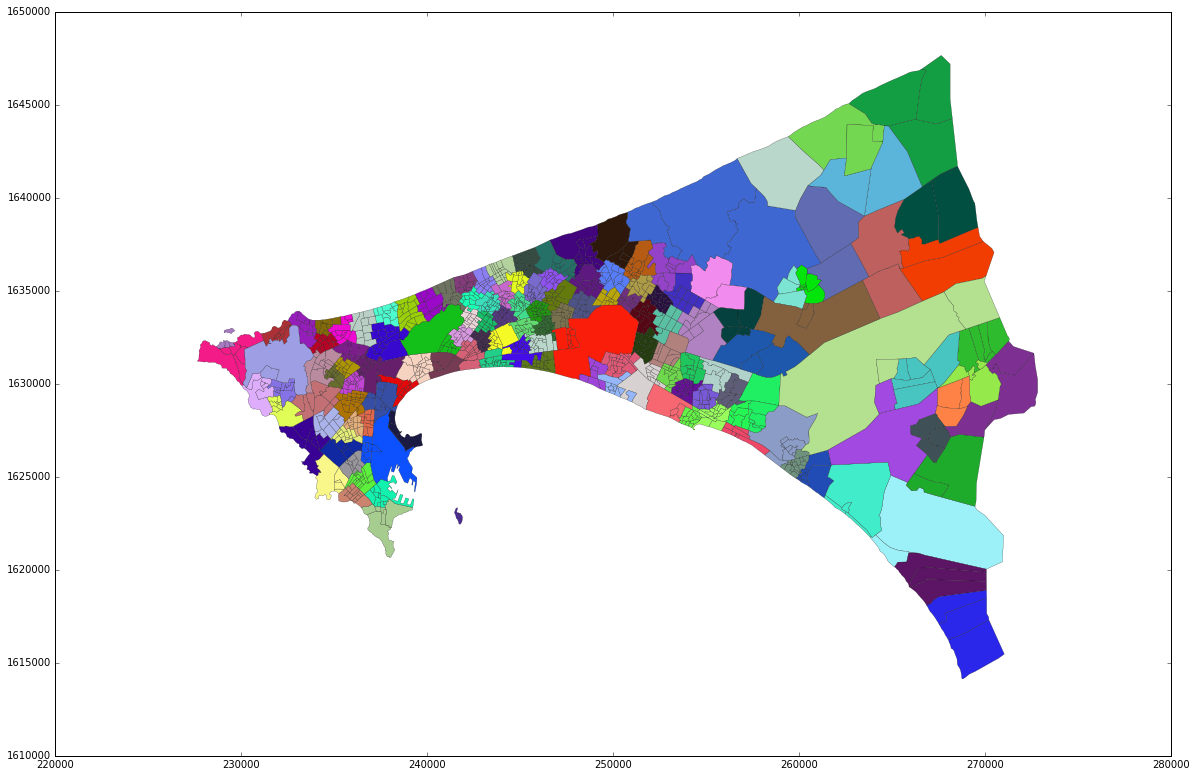

In [169]:
# Display the shape
gdf1.plot(column='cluster', cmap=cmap, lw=0.2, figsize=(20, 20))  #Adapt the column according to your own data

### Display final result - Admin 0 borders

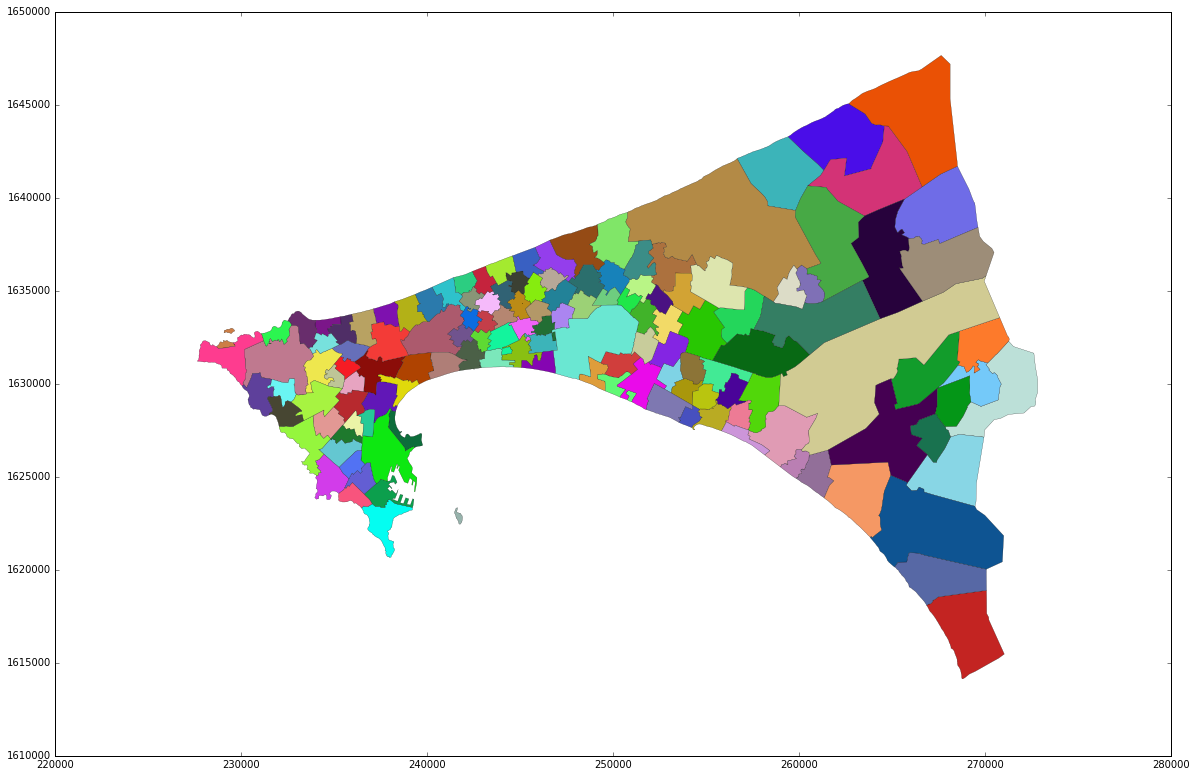

In [171]:
# Display the shape
gdf0.plot(column='cluster', cmap=cmap, lw=0.2, figsize=(20, 20))  #Adapt the column according to your own data

# Export admin1 shapefile

In [ ]:
# Set the path to the shapefile to be created
shape_export = '/media/tais/My_Book_1/MAUPP/Traitement/Population_modelling_dasymetry/Results/Dakar/admin0.shp'
# Export
gdf0.to_file(driver='ESRI Shapefile',filename=shape_export)